## Matching jobs titles to resumes
The challenges in this mini project:<br>
1. The resumes and the jobs were in two different file types.
2. They had to be loaded into the jupyter NB using different methods. 
3. Both were loaded into dictionaries
4. They were converted to dataframes and cleaned.
5. Words were vectorized and then compared using consine similarity.

## Clustering key words from resumes
1. The resume dataframe, from the Matching section, was reused for the clustering section.
2. Normalizing the 'words' column of the resume_df (further cleaning).
3. Finding optimal clusters using K-means clustering.
4. Clusters were plotted on PCA plot and TSNE plot.
5. Words clusters were listed. 

<br>Final thoughts: <br>
The concluding word groups seemed logical. However, this was a small data set. <br> The positions_df was a larger data set. Therefor, clustering key words was redone with the job descriptions.

## Clustering key words from job descriptions.
As expected, the much larger dataset gave way to better results.<br>
It was easier to determine the optimal cluster number for K-means.  <br>
PCA and TSNE graphs showed better defined separation of groups. <br>


In [36]:
import pandas as pd
import numpy as np

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import glob
import docx2txt
import pickle
import re
import os

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
# Load job descriptions and resumes into pandas dictionary
resume = {}
for file in glob.glob("/Users/dahliashamir/Documents/GitHub/NLP_project/CVs/*.docx"):
    resume[file.split('.')[0]] = docx2txt.process(file)


In [7]:
resume_new = {}
for key in resume:
    key.replace(key, key.title())
    new_key = key.lstrip('/Users/dahliashamir/Documents/GitHub/NLP_project/')
    resume[new_key] = resume.pop(key)

In [8]:
resume.keys()

dict_keys(['CVs/Hair-stylist-resume-sample-MSWord-Download', 'CVs/Music-Resume-Sample-MSWord-Download', 'CVs/School-Bus-Driver-Resume-Sample-MSWord-Download', 'CVs/Housekeeping-Resume-Sample-MSWord-Download', 'CVs/combination-janitor-resume-sample-MSWord-download', 'CVs/Construction-Labor-Resume-Sample-MSWord-Download', 'CVs/Sales-Associate-Resume-Sample-MSWord-Download (1)', 'CVs/Truck-Driver-Resume-Sample-MSWord-Download', 'CVs/Flight-Attendant-Resume-MSWord-Download', 'CVs/Bank-Teller-Resume-Sample-MSWord-Download', 'CVs/Bookkeeper-Resume-Sample-MSWord-Download', 'CVs/CDL-Driver-Resume-Sample-Download', 'CVs/Delivery-Driver-Resume-Sample-MSWord-Download', 'CVs/Elementary-Teacher-Resume-Sample-MSWord-Download', 'CVs/Makeup-Artist-Resume-Sample-MSWord-Download', 'CVs/Retail-Manager-Resume-Sample-MSWord-Download', 'CVs/Software-Engineer-Resume-Sample-MSWord-Download', 'CVs/Maintenance-Worker-Resume-Sample-MSWord-Download', 'CVs/Nanny-Resume-Sample-MSWord-Download', 'CVs/Sales-Associate

In [11]:
#clean resume dictionary and prepare for resume dataframe
stop_words = set(stopwords.words('english'))

def resume_dict_to_df(text):
    # make lower case
    low_case = {key: value.lower() for (key, value) in text.items()}
    low_case_key = dict((k.lower(), v) for k, v in low_case.items()) 
    # remove underscore
    no_underscore_resume = {key: value.replace('__', ' ') for (key, value) in low_case_key.items()}
    # remove white spaces
    no_wspace_resume = {key: value.replace("   ", "") for (key, value) in no_underscore_resume.items()}
    # remove \n from values
    nresume = {key: value.replace("\n", "") for (key, value) in no_wspace_resume.items()}
    #dashes_in_key
    final_resume = {key.replace("-", " "): value for (key, value) in nresume.items()}
    resume_df = pd.DataFrame(final_resume, index=[0]).T
    resume_df.reset_index(inplace = True)
    resume_df.rename(columns = {'index':'doc_names', 0: 'words'}, inplace = True)
    return resume_df

resume_df = resume_dict_to_df(resume)
resume_df.head(2)


,doc_names,words
0,cvs/hair stylist resume sample msword download,hair stylist resume sample(843) 354-2125 | jes...
1,cvs/music resume sample msword download,music resume samplemusic@gmail.com | 123 your ...


In [12]:
# Uploading pickle files to dictionary.
directory = '/Users/dahliashamir/Documents/GitHub/NLP_project/positions'
os.chdir(directory)
# Create empty dictionary to save data
pos_dict = {}

# Loop over files and read pickles
for file in os.listdir(directory):
    if file.endswith('.pkl') :
        with open(file, 'rb') as f:
            pos_dict[file.split('.')[0]] = pickle.load(f)

In [13]:
#pos_dict had many unnecessary detail. This was simplified to job_kw dictionary (one key and one value).
job_kw = {}
for v in pos_dict.values():
    job_kw.update({v['title'] : v['basic_qualifications']})
    
#print(job_kw['Senior UX Designer, AWS Honeycode'])

In [14]:
# Convert resume dict to resume df
def postion_dict_to_df(job_kw):
    positions_df = pd.DataFrame(job_kw, index=[0]).T
    positions_df.reset_index(inplace = True)
    #positions_df.columns
    positions_df.rename(columns = {'index':'job_title', 0: 'job_description'}, inplace = True)
    return positions_df

positions_df = postion_dict_to_df(job_kw)

In [15]:
# Clean job descriptions and resumes by removing punctuation, stop words, and converting all text to lowercase.
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = ''.join([word for word in text if word.isalnum() or word.isspace()])
    tokens = word_tokenize(text)
    text = [word for word in tokens if word not in stop_words]
    return ' '.join(text)

positions_df['clean_description'] = positions_df['job_description'].apply(lambda x: clean_text(x))
resume_df['clean_resume'] = resume_df['words'].apply(lambda x: clean_text(x))

In [16]:
# Match job descriptions to resumes using cosine similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

tfidf_vectorizer = TfidfVectorizer()
tfidf_jobs = tfidf_vectorizer.fit_transform(positions_df['clean_description'])
tfidf_resumes = tfidf_vectorizer.transform(resume_df['clean_resume'])

matches = []
for i, resume in enumerate(tfidf_resumes):
    similarities = cosine_similarity(resume, tfidf_jobs)[0]
    job_index = similarities.argmax()
    job_title = positions_df.iloc[job_index]['job_title']
    matches.append({'resume_index': i, 'job_title': job_title})

# Print the matches
for match in matches:
    print(f"Resume {match['resume_index']} matches with job '{match['job_title']}'")
print(resume_df['clean_resume'])

Resume 0 matches with job 'Principal Business Development Lead – Greenfield GTM Strategy'
Resume 1 matches with job 'Global Latin Music Programmer, Music Industry'
Resume 2 matches with job 'Amazon Fresh Overnight Grocery Associate - Woodland Hills, Ca'
Resume 3 matches with job 'AWS Communications Leader '
Resume 4 matches with job 'Data Center Construction Manager (New Zealand), Data Center Planning & Delivery'
Resume 5 matches with job 'Data Center Construction Manager (New Zealand), Data Center Planning & Delivery'
Resume 6 matches with job 'Principal Business Development Lead – Greenfield GTM Strategy'
Resume 7 matches with job 'IT Support Associate II, OpsTechIT'
Resume 8 matches with job 'Onsite Medical Representative, WHS'
Resume 9 matches with job 'Cloud Support Eng. I (DEP)'
Resume 10 matches with job 'Principal IT App Analyst- Management Financial, AWS Fintech'
Resume 11 matches with job 'Carrier Manager'
Resume 12 matches with job 'SDE II (Embedded Firmware) Amazon Glow, Am

## Clustering the CVs

### 1. resume_df, which was converted from resume dict will be used. 

### 2. Normalize Data in words column <br>
https://www.geeksforgeeks.org/normalizing-textual-data-with-python/ <br>
- make all letters lower case <br>
- remove all non-essensial numbers <br>
- remove punctuation marks <br>
- remove stop words 

In [62]:
# make lower case
resume_df['words'] = resume_df['words'].str.lower()

# remove numbers
resume_df['words'] = [re.sub(r'\d+','', str(x)) for x in resume_df['words']]

# remove punctuation marks
resume_df['words'] = [re.sub(r'[^\w\s]', '', str(x)) for x in resume_df['words']]

# remove underscore
resume_df['words'] = resume_df['words'].str.replace('__', ' ')

# remove \n from values
resume_df['words'] = resume_df['words'].str.replace("\n", "")

# remove xxx from values
resume_df['words'] = resume_df['words'].str.replace("xxx", "")

# remove white spaces
resume_df['words'] = resume_df['words'].str.strip()

resume_df.words.head()

0    hair stylist resume sample   jessicawoodleygma...
1    music resume samplemusicgmailcom   your addres...
2    school bus driver resume sample evergreen terr...
3    housekeeping resume sample kelley avenue new o...
4    janitor resume combination santa monica blvd l...
Name: words, dtype: object

### 3. Extracting Keywords 
The TfidfVectorizer was used with the hopes that the IDF score will found some unique words that can be used in the clustering.

In [63]:
tfidf = TfidfVectorizer(
    min_df = 5,
    max_df = 0.95,
    max_features = 2000,
    stop_words = 'english'
)
tfidf.fit(resume_df.words)
text = tfidf.transform(resume_df.words)

### 4. Finding Optimal Number of Clusters to use.
https://towardsdatascience.com/deep-learning-for-semantic-text-matching-d4df6c2cf4c5 <br>
This section used K-means clustering to cluster the CVs. This type of ML is unsupervised. For K-means we must specify the cluster amount. This plot wasn't too helpful but since there was a small bump around 8 clusters I decided to go with that cluster amount. 


Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters


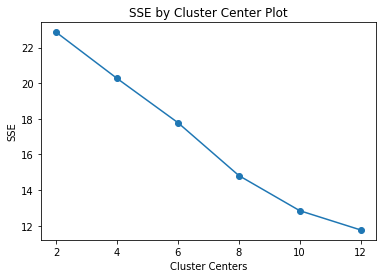

In [64]:
def find_optimal_clusters(resume_df, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, 
                                   random_state=20).fit(resume_df).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(text, 12)

### Plotting the clusters:
Two plots were made: PCA and TSNE. Neither one showed great separation but PCA was a bit better.

In [65]:
clusters = MiniBatchKMeans(n_clusters=8, init_size=1024, batch_size=2048, random_state=20).fit_predict(text)

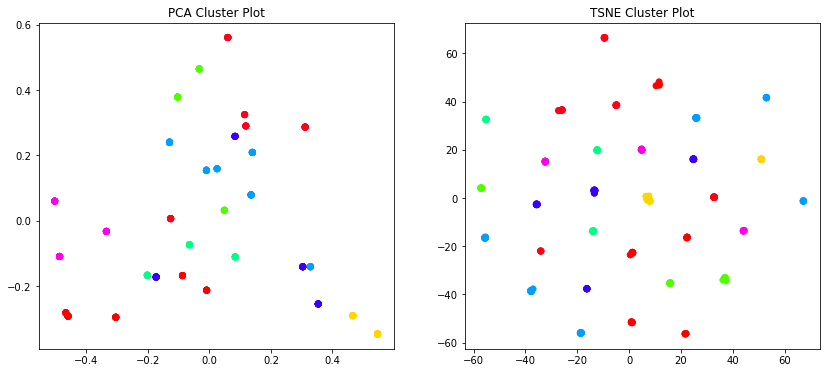

In [66]:
def plot_tsne_pca(resume_df, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(resume_df.shape[0]), size=3000)
    
    pca = PCA(n_components=2).fit_transform(resume_df[max_items,:].todense())
    tsne = TSNE().fit_transform(PCA(n_components=10).fit_transform(resume_df[max_items,:].todense()))
    
    
    idx = np.random.choice(range(pca.shape[0]), size=300, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')
    
plot_tsne_pca(text, clusters)

### Conclusions: finding the best keywords for each cluster.
This data set was relatively small however clusters seem mostly logical. 

In [67]:
def best_keywords(resume_df, clusters, labels, n_terms):
    df = pd.DataFrame(resume_df.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(', '.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
            
best_keywords(text, clusters, tfidf.get_feature_names(), 10)


Cluster 0
august, skills, quality, ca, including, duties, maintenance, safety, repair, equipment

Cluster 1
service, boston, september, quality, team, goals, store, ma, customers, sales

Cluster 2
september, management, education, west, th, software, arts, school, english, testing

Cluster 3
equipment, service, record, work, information, maintaining, maintenance, degree, daily, inventory

Cluster 4
th, west, additional, suite, ca, street, new, clients, ny, york

Cluster 5
administration, routes, experience, clients, management, arts, customers, ca, service, customer

Cluster 6
time, mechanical, chicago, routes, safety, commercial, license, class, school, drivers

Cluster 7
management, city, experience, certified, processes, gpa, annual, business, university, state


## Clustering the Jobs
use clean_description column from positions_df <br>
Data looks normalized so we proceed to the vectorization of the words.

In [68]:
positions_df.head()

,job_title,job_description,clean_description
0,"Senior UX Designer, AWS Honeycode",* Must have an online portfolio that demonstra...,must online portfolio demonstrates ux usercent...
1,"Sr. Program Manager, Amazon Home Services",<ul><li>5+ years of experience in program or p...,ulli5 years experience program project managem...
2,Accounting Manager - Global Financial Accounti...,<ul><li>8+ years of finance experience or a re...,ulli8 years finance experience related analyti...
3,Operations Lead,A graduate with 1-3 yrs of experience in a cus...,graduate 13 yrs experience customer facing env...
4,Amazon Fresh Overnight Grocery Associate - Woo...,<ul><li>High school or equivalent diploma</li>...,ullihigh school equivalent diplomaliul


### 1. Extracting Keywords 
The TfidfVectorizer was used with the hopes that the IDF score will found some unique words that can be used in the clustering.

In [69]:

tfidf = TfidfVectorizer(
    min_df = 5,
    max_df = 0.95,
    max_features = 2000,
    stop_words = 'english'
)
tfidf.fit(positions_df.clean_description)
job_text = tfidf.transform(positions_df.clean_description)

### 2. Cluster number determination for Job Descriptions
Three definative elbows can be seen. The elbow shows a difinative change in inertia. They are at 8, 14 and 20. All three were tested.<br> 20 had the cleanest clusters but 14 the sample keywords within the clusters made the most logical sense.

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters
Fit 22 clusters


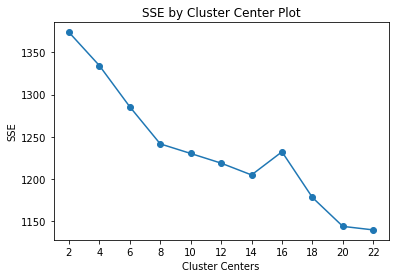

In [82]:
def find_optimal_clusters(positions_df, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, 
                                   random_state=20).fit(positions_df).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(job_text, 22)

### Plotting the clusters:
Two plots were made: PCA and TSNE. Neither one showed great separation but PCA was a bit better.

In [83]:
clusters = MiniBatchKMeans(n_clusters=14, init_size=1024, batch_size=2048, random_state=20).fit_predict(job_text)

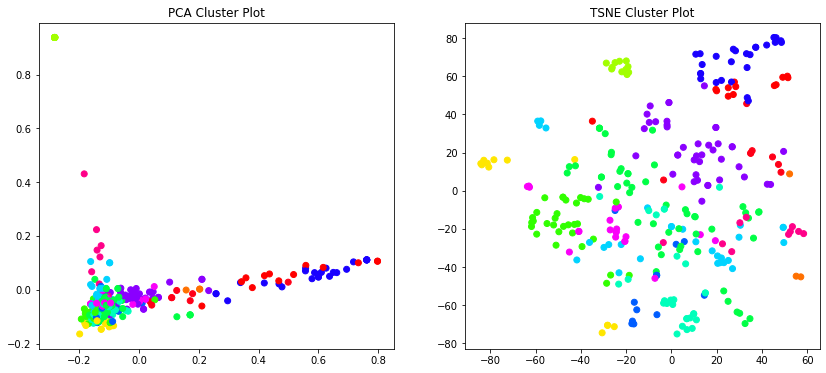

In [84]:
def plot_tsne_pca(positions_df, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(positions_df.shape[0]), size=3000)
    
    pca = PCA(n_components=2).fit_transform(positions_df[max_items,:].todense())
    tsne = TSNE().fit_transform(PCA(n_components=10).fit_transform(positions_df[max_items,:].todense()))
    
    
    idx = np.random.choice(range(pca.shape[0]), size=300, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')
    
plot_tsne_pca(job_text, clusters)

### Conclusions: finding the best keywords for each cluster using positions_df.
Since the dataset was larger the clustering could be better analyzed. There was a bit a noise around nonsense words. For improved results further cleaning is needed. 

In [85]:
def best_keywords(positions_df, clusters, labels, n_terms):
    df = pd.DataFrame(positions_df.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(', '.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
            
best_keywords(job_text, clusters, tfidf.get_feature_names(), 10)


Cluster 0
new, software, current, experience, patterns, scaling, reliability, years, design, architecture

Cluster 1
developmentliulbr, computer, developmentliulbrbr, years, experience, programming, developmentliul, ulliprogramming, languagelili1, software

Cluster 2
communicating, improvementsliliexperience, experience, managementliliexperience, owning, delivery, product, program, strategy, end

Cluster 3
et, establishing, evaluate, years, including, roleliul, equivalent, school, ullihigh, diplomaliul

Cluster 4
verbal, management, proven, written, experience, communication, business, strong, skills, ability

Cluster 5
product, analytical, engineering, managing, degree, related, management, finance, years, experience

Cluster 6
using, visualization, science, machine, statistics, sql, business, years, experience, data

Cluster 7
written, outlook, english, knowledge, ms, word, excel, microsoft, und, office

Cluster 8
functionally, nontech, data, metrics, using, years, cross, br, progra